In [37]:
# Optimizing Smart Grid Energy Distribution using CUDA-Accelerated Genetic Algorithm

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

In [49]:
# === Enhanced Smart Grid Demand Generation ===

torch.manual_seed(42)

# Core parameters
num_nodes = 500
num_sources = 3
hours = 24

# === 1. Assign consumer types: 1 - Residential, 2 - Commercial, 3 - Industrial
consumer_types = torch.randint(1, 4, (num_nodes, 1)).float()

# === 2. Assign income levels: 1 - Low, 2 - Middle, 3 - High
income_level = torch.randint(1, 4, (num_nodes, 1)).float()
income_factor = torch.where(
    income_level == 1, 0.8,
    torch.where(income_level == 2, 1.0, 1.2)
)

# === 3. Assign zones (location groups)
zones = torch.randint(0, 5, (num_nodes, 1))
zone_bias = torch.tensor([1.2, 1.1, 1.0, 0.9, 0.8])[zones].squeeze()  # 5 zone multipliers

# === 4. Generate type-specific base demand
res_range = (30, 100)
com_range = (70, 140)
ind_range = (120, 250)
base_demand = torch.zeros((num_nodes, hours))
for t in range(1, 4):
    idx = (consumer_types == t).squeeze()
    low, high = [res_range, com_range, ind_range][t - 1]
    base_demand[idx] = torch.randint(low, high, (idx.sum(), hours), dtype=torch.float32)

# === 5. Time-of-day usage pattern
time_curve = torch.tensor([
    0.6, 0.5, 0.4, 0.4, 0.5, 0.6,
    0.8, 1.0, 1.3, 1.1, 1.0, 0.9,
    0.8, 0.7, 0.8, 0.9, 1.1, 1.4,
    1.3, 1.1, 1.0, 0.9, 0.8, 0.7
])
time_factors = time_curve.view(1, -1)

# === 6. Weekday/weekend modifier
weekday_factors = torch.tensor([1.0 if h % 7 < 5 else 0.8 for h in range(hours)]).view(1, -1)

# === 7. Add node-specific noise
noise = 0.05 * torch.randn((num_nodes, hours))

# === 8. Monthly/seasonal multiplier
seasonal_factor = torch.tensor([
    0.9, 0.9, 1.0, 1.1, 1.2, 1.3,
    1.3, 1.2, 1.1, 1.0, 0.95, 0.9
])  # Jan–Dec
month = torch.randint(0, 12, (1,))
season_scale = seasonal_factor[month].item()

# === 9. Type bias (residential/commercial/industrial)
type_bias = consumer_types * 10

# === 10. Final demand calculation
demand = (
    base_demand * time_factors * weekday_factors * income_factor
    + type_bias + noise
)
demand *= zone_bias.view(-1, 1)
demand *= season_scale
demand = demand.clamp(min=50, max=350)


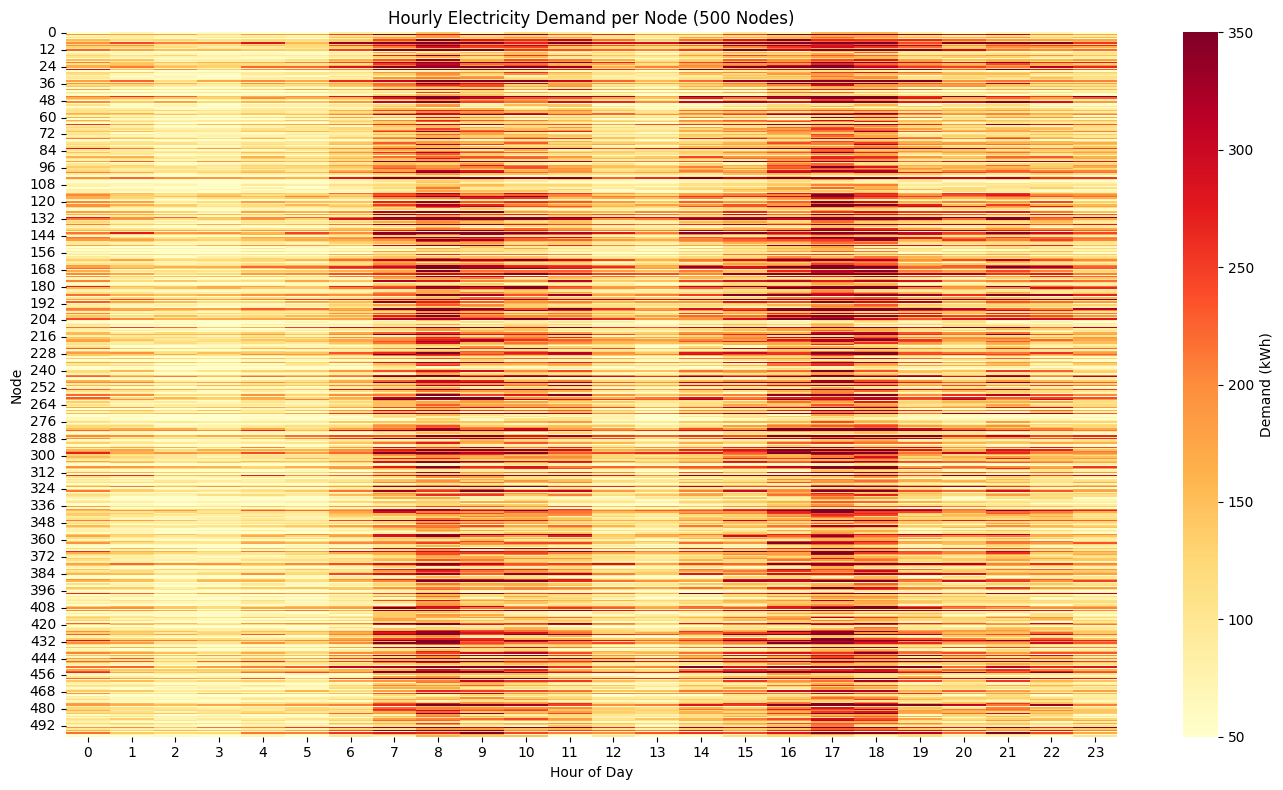

In [50]:
# ==== 2. VISUALIZE DEMAND ====
plt.figure(figsize=(14, 8))
sns.heatmap(demand.numpy(), cmap="YlOrRd", cbar_kws={'label': 'Demand (kWh)'})
plt.xlabel("Hour of Day")
plt.ylabel("Node")
plt.title("Hourly Electricity Demand per Node (500 Nodes)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_6142/3155406110.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=consumer_types.squeeze().int(), palette='Set2')


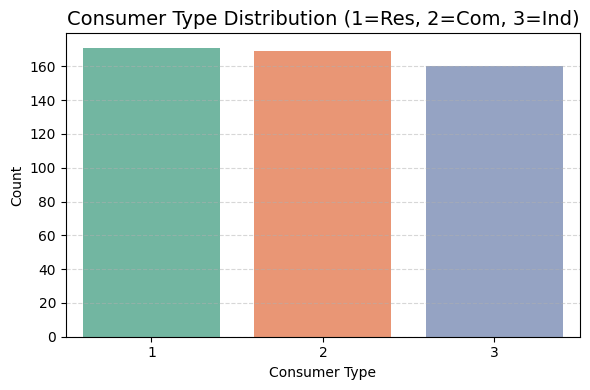

In [113]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=consumer_types.squeeze().int(), palette='Set2')
plt.title("Consumer Type Distribution (1=Res, 2=Com, 3=Ind)", fontsize=14)
plt.xlabel("Consumer Type")
plt.ylabel("Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_6142/3978135354.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=income_level.squeeze().int(), palette='pastel')


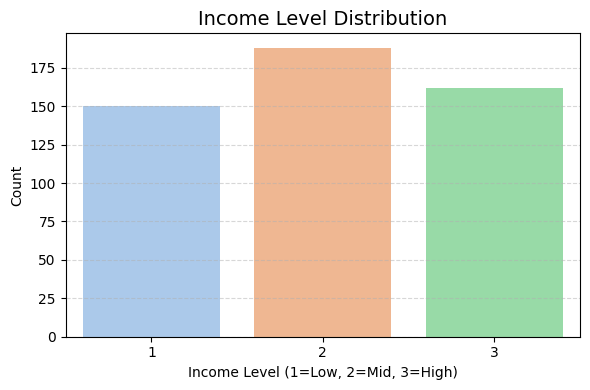

In [114]:
plt.figure(figsize=(6, 4))
sns.countplot(x=income_level.squeeze().int(), palette='pastel')
plt.title("Income Level Distribution", fontsize=14)
plt.xlabel("Income Level (1=Low, 2=Mid, 3=High)")
plt.ylabel("Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_6142/3135991770.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=zones.squeeze().int(), palette='coolwarm')


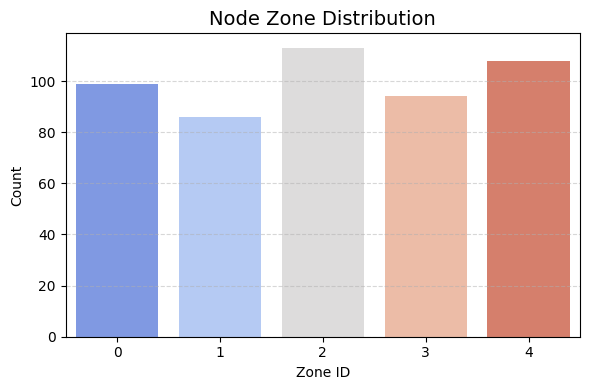

In [115]:
plt.figure(figsize=(6, 4))
sns.countplot(x=zones.squeeze().int(), palette='coolwarm')
plt.title("Node Zone Distribution", fontsize=14)
plt.xlabel("Zone ID")
plt.ylabel("Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

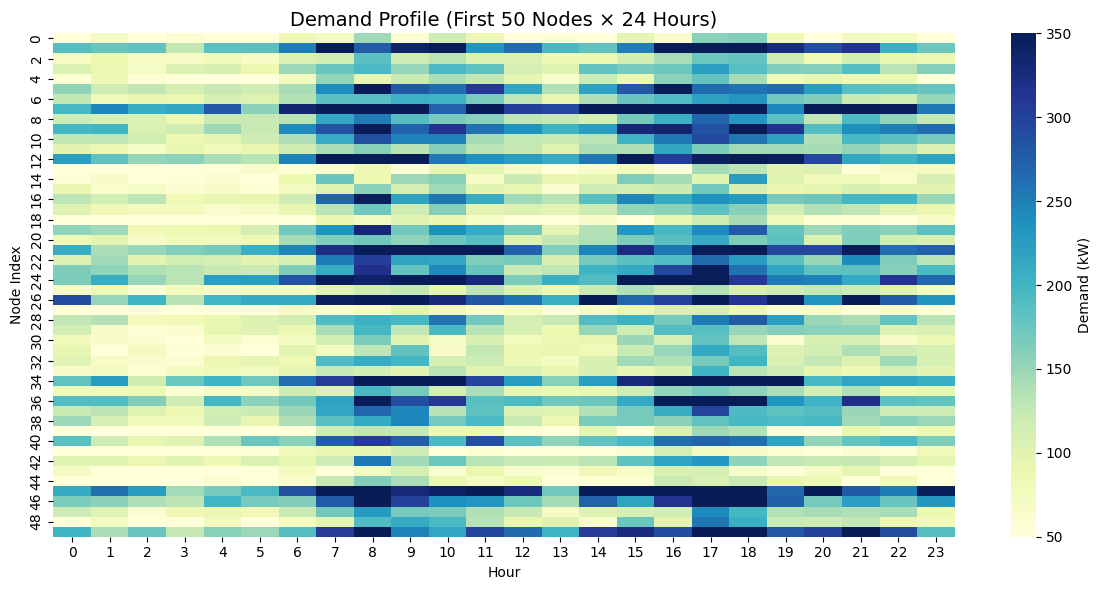

In [116]:
plt.figure(figsize=(12, 6))
sns.heatmap(demand[:50], cmap='YlGnBu', cbar_kws={'label': 'Demand (kW)'})
plt.title("Demand Profile (First 50 Nodes × 24 Hours)", fontsize=14)
plt.xlabel("Hour")
plt.ylabel("Node Index")
plt.tight_layout()
plt.show()

In [51]:
# ==== 3. GA PARAMETERS ====
population_size = 512
generations = 300
gene_length = num_nodes * num_sources * hours

mutation_rate_start = 0.2
mutation_rate_end = 0.01
mutation_rate_decay = (mutation_rate_start - mutation_rate_end) / generations

crossover_rate = 0.9
use_elitism = True
elitism_count = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
# ==== 4. INIT POPULATION ====
def init_population(pop_size, length):
    return torch.rand((pop_size, length), device=device)

In [105]:
# ==== 5. FITNESS FUNCTION ====
def compute_fitness(pop):
    pop_reshaped = pop.view(pop.size(0), num_nodes, num_sources, hours)
    losses = pop_reshaped * loss_coef.to(device).unsqueeze(-1)
    net_energy = pop_reshaped - losses

    total_supplied = net_energy.sum(dim=2)
    demand_rep = demand.to(device).unsqueeze(0)
    under = torch.relu(demand_rep - total_supplied)
    over = torch.relu(total_supplied - demand_rep)

    demand_penalty = (under ** 2).sum(dim=(1, 2))
    oversupply_penalty = (over ** 2).sum(dim=(1, 2))

    storage_use = over.sum(dim=2)
    storage_limits_rep = storage_limits.to(device).unsqueeze(0).repeat(pop.size(0), 1)
    storage_penalty = torch.relu(storage_use - storage_limits_rep).sum(dim=1)

    dynamic_capacity = dynamic_source_capacity.to(device).unsqueeze(0).repeat(pop.size(0), 1, 1)
    supply_totals = pop_reshaped.sum(dim=1)
    supply_penalty = torch.relu(supply_totals - dynamic_capacity).sum(dim=(1, 2))

    cost_matrix = pop_reshaped * source_cost.to(device).view(1, 1, -1, 1) * peak_hours.to(device).view(1, 1, 1, -1)
    total_cost = cost_matrix.sum(dim=(1, 2, 3))

    fitness = - (
        total_cost
        + 0.1 * demand_penalty 
        + 0.05 * oversupply_penalty
        + 0.05 * supply_penalty 
        + 0.03 * storage_penalty 
    )

    return fitness

In [106]:
def normalize_fitness(fitness_scores):
    max_fit = max(fitness_scores)
    min_fit = min(fitness_scores)
    return [(f - min_fit) / (max_fit - min_fit + 1e-8) for f in fitness_scores]

In [107]:
# ==== 6. CROSSOVER & MUTATION ====
def crossover(parent1, parent2):
    mask = torch.rand_like(parent1) < 0.5
    return torch.where(mask, parent1, parent2)

def mutate(child, mutation_rate):
    mutation = torch.rand_like(child) < mutation_rate
    noise = torch.rand_like(child) * 0.1
    return torch.where(mutation, child + noise, child)

In [108]:
# ==== 7. RUN GA PARALLEL ====
def run_ga_parallel():
    population = init_population(population_size, gene_length)
    best_fitness = []
    avg_fitness = []

    for gen in range(generations):
        current_mutation_rate = max(mutation_rate_end, mutation_rate_start - gen * mutation_rate_decay)
        fitness = compute_fitness(population)
        if use_elitism:
            elite_indices = torch.topk(fitness, elitism_count).indices
            elites = population[elite_indices]

        best_fitness.append(fitness.max().item())
        avg_fitness.append(fitness.mean().item())

        probs = (fitness - fitness.min()) + 1e-6
        probs = probs / probs.sum()
        parents_idx = torch.multinomial(probs, population_size, replacement=True)
        parents = population[parents_idx]

        next_gen = [elites[i] for i in range(elitism_count)]
        for i in range(0, population_size - elitism_count, 2):
            if torch.rand(1).item() < crossover_rate:
                child1 = crossover(parents[i], parents[i+1])
                child2 = crossover(parents[i+1], parents[i])
            else:
                child1, child2 = parents[i], parents[i+1]

            next_gen.append(mutate(child1, current_mutation_rate))
            next_gen.append(mutate(child2, current_mutation_rate))

        population = torch.stack(next_gen).clamp(0, dynamic_source_capacity.max().item())

        if gen % 20 == 0:
            rand_idx = torch.randint(0, population_size, (5,))
            population[rand_idx] = init_population(5, gene_length)

    return best_fitness, avg_fitness

In [109]:
# ==== 8. RUN GA SERIAL ====
def run_ga_serial():
    population = init_population(population_size, gene_length).cpu()
    best_fitness = []

    for gen in range(generations):
        fitness = compute_fitness(population.to(device)).cpu()
        if use_elitism:
            elite_indices = torch.topk(fitness, elitism_count).indices
            elites = population[elite_indices]

        best_fitness.append(fitness.max().item())

        probs = (fitness - fitness.min()) + 1e-6
        probs = probs / probs.sum()
        parents_idx = torch.multinomial(probs, population_size, replacement=True)
        parents = population[parents_idx]
        current_mutation_rate = max(mutation_rate_end, mutation_rate_start - gen * mutation_rate_decay)

        next_gen = [elites[i] for i in range(elitism_count)]
        for i in range(0, population_size - elitism_count, 2):
            if np.random.rand() < crossover_rate:
                child1 = crossover(parents[i], parents[i+1])
                child2 = crossover(parents[i+1], parents[i])
            else:
                child1, child2 = parents[i], parents[i+1]

            next_gen.append(mutate(child1, current_mutation_rate))
            next_gen.append(mutate(child2, current_mutation_rate))


        population = torch.stack(next_gen).clamp(0, dynamic_source_capacity.max().item())

        if gen % 20 == 0:
            rand_idx = torch.randint(0, population_size, (5,))
            population[rand_idx] = init_population(5, gene_length).cpu()

    return best_fitness

In [110]:
# ==== 9. EXECUTE AND TIME ====
start = time.time()
gpu_best_fitness, gpu_avg_fitness = run_ga_parallel()
gpu_time = time.time() - start

start = time.time()
cpu_best_fitness = run_ga_serial()
cpu_time = time.time() - start

print(f"GPU Time: {gpu_time:.2f}s | CPU Time: {cpu_time:.2f}s")
speedup = cpu_time / gpu_time
print(f"GPU Speedup Factor: {speedup:.2f}x")

GPU Time: 16.69s | CPU Time: 115.17s
GPU Speedup Factor: 6.90x


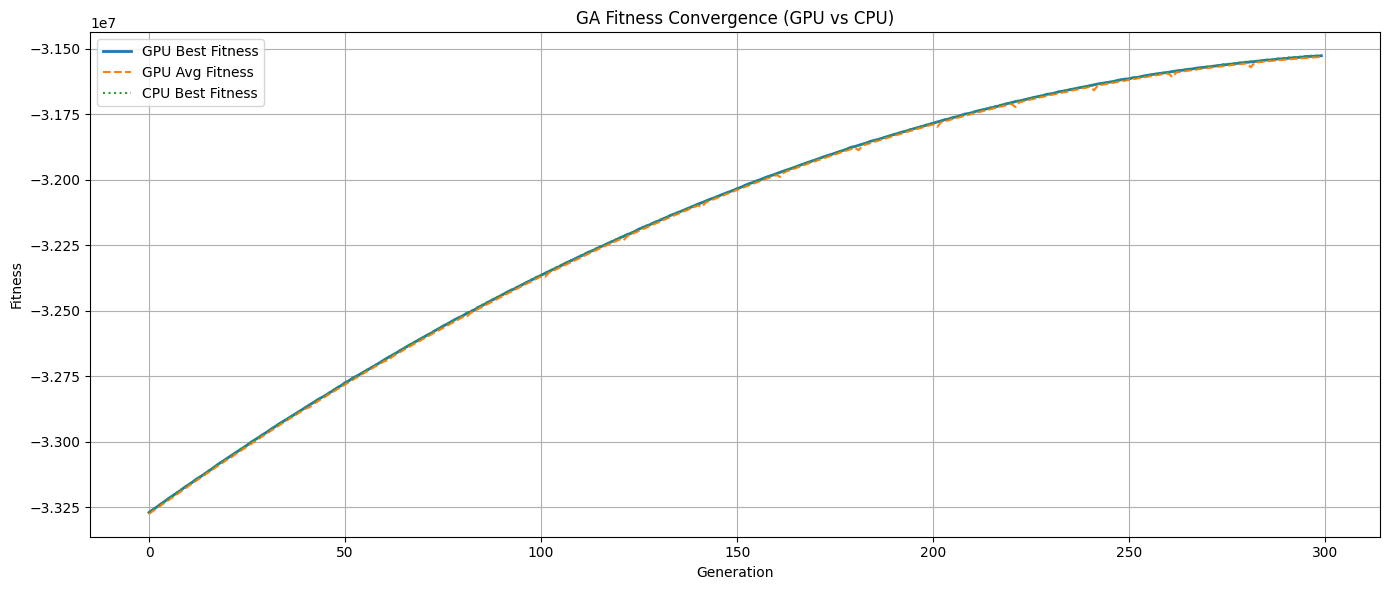

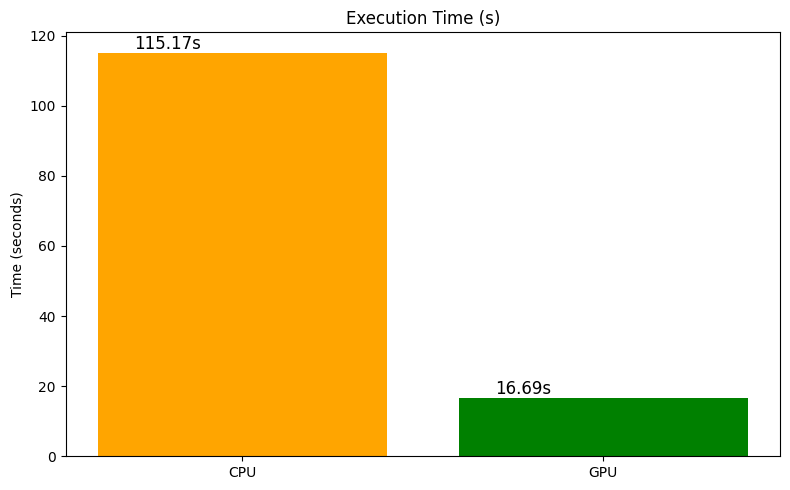

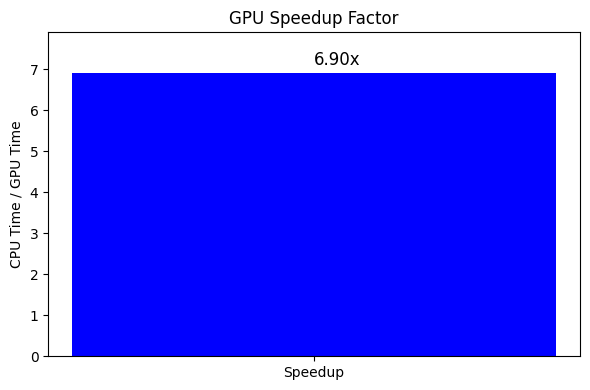

In [111]:
# ==== 10. VISUALIZATION ====
plt.figure(figsize=(14, 6))
plt.plot(gpu_best_fitness, label='GPU Best Fitness', linewidth=2)
plt.plot(gpu_avg_fitness, label='GPU Avg Fitness', linestyle='--')
plt.plot(cpu_best_fitness, label='CPU Best Fitness', linestyle=':')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('GA Fitness Convergence (GPU vs CPU)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]
bars = plt.bar(labels, times, color=['orange', 'green'])
plt.title('Execution Time (s)')
plt.ylabel('Time (seconds)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.1, yval + 1, f'{yval:.2f}s', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['Speedup'], [speedup], color='blue')
plt.ylabel('CPU Time / GPU Time')
plt.title('GPU Speedup Factor')
plt.ylim(0, max(speedup + 1, 5))
plt.text(0, speedup + 0.2, f'{speedup:.2f}x', fontsize=12)
plt.tight_layout()
plt.show()

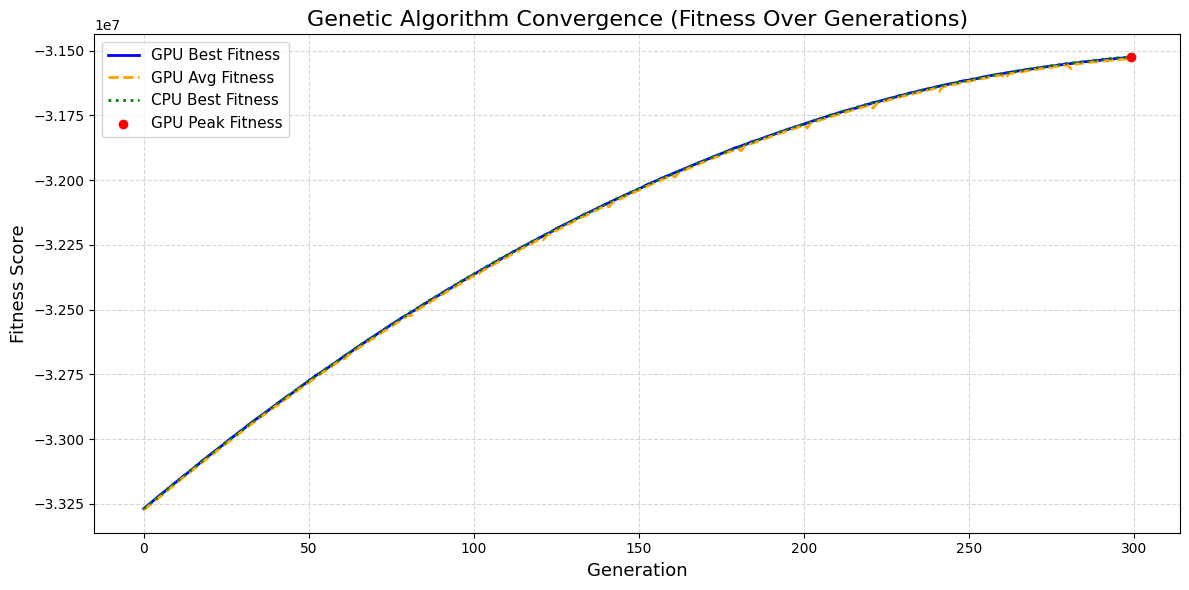

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy for safety
gens = list(range(len(gpu_best_fitness)))
gpu_best = np.array(gpu_best_fitness)
gpu_avg = np.array(gpu_avg_fitness)
cpu_best = np.array(cpu_best_fitness)

plt.figure(figsize=(12, 6))

# Plot lines
plt.plot(gens, gpu_best, label='GPU Best Fitness', color='blue', linewidth=2)
plt.plot(gens, gpu_avg, label='GPU Avg Fitness', color='orange', linestyle='--', linewidth=2)
plt.plot(gens, cpu_best, label='CPU Best Fitness', color='green', linestyle=':', linewidth=2)

# Highlight best fitness achieved
max_fitness = gpu_best.max()
max_gen = gpu_best.argmax()
plt.scatter(max_gen, max_fitness, color='red', label='GPU Peak Fitness', zorder=5)

# Formatting
plt.title("Genetic Algorithm Convergence (Fitness Over Generations)", fontsize=16)
plt.xlabel("Generation", fontsize=13)
plt.ylabel("Fitness Score", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


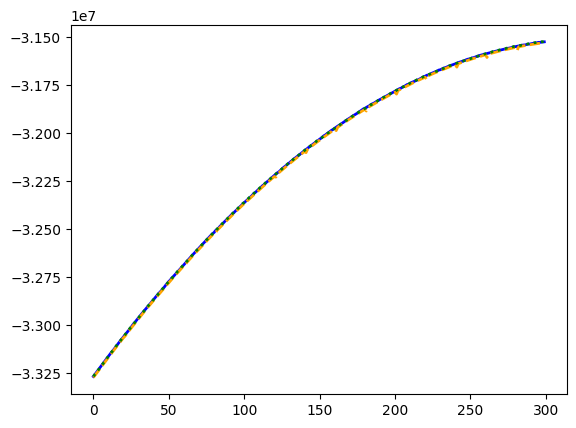

In [117]:
plt.plot(gpu_best_fitness, label='GPU Best Fitness', color='blue', linewidth=2)
plt.plot(gpu_avg_fitness, label='GPU Avg Fitness', color='orange', linestyle='--', linewidth=2)
plt.plot(cpu_best_fitness, label='CPU Best Fitness', color='green', linestyle=':', linewidth=2)
